In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing
import sklearn.decomposition
import sklearn.model_selection
import sklearn.svm
import sklearn.inspection
import sklearn.feature_selection
from sklearn.experimental import enable_halving_search_cv

In [5]:
import sklearn.pipeline
import sklearn.ensemble

In [2]:
df = pd.read_csv('npf_train.csv')

class2 = np.array(["event"]*df.shape[0],dtype="object")
class2[df["class4"]=="nonevent"] = "nonevent"
df["class2"] = class2
df["class2"] = df["class2"].astype("category")

not_needed_columns = ["partlybad", "id", "date"]
df = df.drop(not_needed_columns, axis=1)

class2_categories = {
    "nonevent": 0,
    "event": 1
}

class4_categories = {
    "nonevent": 0,
    "Ia": 1,
    "Ib": 2,
    "II": 3
}

def categorize_class2(row):
    row["class2"] = class2_categories[row["class2"]]
    
    return row
def categorize_class4(row):
    row["class4"] = class4_categories[row["class4"]]
    
    return row

df = df.apply(lambda row: categorize_class2(row), axis=1)
df = df.apply(lambda row: categorize_class4(row), axis=1)
df["class2"] = df["class2"].astype("category")
df["class4"] = df["class4"].astype("category")

In [3]:
X_df = df.loc[:, ~df.columns.isin(['class2', 'class4'])].copy()
Y_2 = df['class2'].copy()
Y_4 = df['class4'].copy()

X = X_df.values
y_2 = Y_2.values
y_4 = Y_4.values

In [15]:
# Feature selection using Recursive feature elimination with cross-validation

def feature_selection_RFE(X, y):
    pipeline_rfe = sklearn.pipeline.Pipeline(
                        [('scaler', sklearn.preprocessing.StandardScaler()), 
                        ('feature_selection', sklearn.feature_selection.RFECV(
                                                estimator=sklearn.svm.LinearSVC(penalty="l1", C=0.75, 
                                                max_iter=10**5, dual=False, random_state=0), 
                                                step=1, cv=10, scoring="accuracy", min_features_to_select=1))]
    )
    
    pipeline_rfe.fit(X, y)
    return pipeline_rfe

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 RFECV(cv=10,
                       estimator=LinearSVC(C=0.75, dual=False, max_iter=100000,
                                           penalty='l1', random_state=0),
                       scoring='accuracy'))])

Best number of features:  16


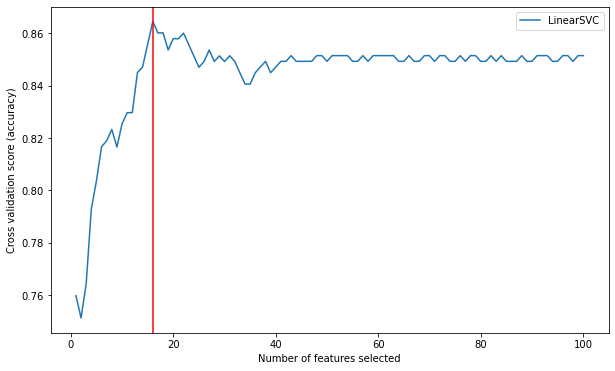

In [32]:
pipeline_rfe_c2 = feature_selection_RFE(X, y_2)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, len(pipeline_rfe_c2[1].cv_results_['mean_test_score'])+1), 
             y=pipeline_rfe_c2[1].cv_results_['mean_test_score'], label='LinearSVC', ax=ax)
ax.set_xlabel('Number of features selected')
ax.set_ylabel('Cross validation score (accuracy)')
ax.axvline(x=16, c='r')

print('Best number of features: ', np.argmax(pipeline_rfe_c2[1].cv_results_['mean_test_score'])+1)

In [33]:
# Selected features

selected_features_rfe = pipeline_rfe.get_feature_names_out(X_df.columns)
selected_features_idx_rfe = np.array([list(X_df.columns).index(i) for i in selected_features_rfe])

print('Selected features: ', selected_features_rfe)

Selected features:  ['CO2336.std' 'H2O336.std' 'H2O42.std' 'H2O504.mean' 'NOx672.mean'
 'O3672.mean' 'PAR.mean' 'PAR.std' 'RHIRGA168.std' 'RHIRGA672.mean'
 'SWS.mean' 'SWS.std' 'T42.std' 'T672.std' 'UV_A.mean' 'CS.mean']


In [36]:
X_selected = X[:, selected_features_idx_rfe]

In [40]:
# Selected classifier: RandomForestClassifier

pipeline_rf = sklearn.pipeline.Pipeline(
                [('scaler', sklearn.preprocessing.StandardScaler()), 
                 #("feature_selection", sklearn.feature_selection.RFECV(
                 #                        estimator=sklearn.svm.LinearSVC(penalty="l1", C=0.75, max_iter=10**5,
                 #                                                        dual=False, random_state=0), 
                 #                        cv=10, scoring="accuracy")), 
                 ('clf', sklearn.ensemble.RandomForestClassifier(random_state=0))]
    )

param_grid = {'clf__n_estimators':np.arange(10, 210, 10), 'clf__criterion':['gini', 'entropy']}
param_search = sklearn.model_selection.HalvingGridSearchCV(pipeline_rf, param_grid, cv=10, n_jobs=4)

param_search.fit(X_selected, y_2)

HalvingGridSearchCV(cv=10,
                    estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('clf',
                                               RandomForestClassifier(random_state=0))]),
                    n_jobs=4,
                    param_grid={'clf__criterion': ['gini', 'entropy'],
                                'clf__n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])})

In [44]:
print('Best RFC model: ', param_search.best_params_, param_search.best_score_)

Best RFC model:  {'clf__criterion': 'gini', 'clf__n_estimators': 80} 0.8685714285714287


In [50]:
pipeline_rf_best = sklearn.pipeline.Pipeline(
                        [('scaler', sklearn.preprocessing.StandardScaler()), 
                         ('clf', sklearn.ensemble.RandomForestClassifier(n_estimators=80, random_state=0))]
    )

cv_scores_c2 = sklearn.model_selection.cross_val_score(pipeline_rf_best, X_selected, y_2, cv=10)

In [51]:
# Print accuracy

print('class2 accuracy: ', np.mean(cv_scores_c2))

class2 accuracy:  0.8646376811594203


In [52]:
# class4

cv_scores_c4 = sklearn.model_selection.cross_val_score(pipeline_rf_best, X_selected, y_4, cv=10)

In [55]:
# Print accuracy

print('class2 accuracy: ', np.mean(cv_scores_c4))

class2 accuracy:  0.6483091787439613


## Producing answers.csv

In [56]:
test_df = pd.read_csv('./npf_test_hidden.csv')

In [59]:
X_test_df = test_df[X_df.columns].copy()
X_test = test_df[X_df.columns].values
X_test_sel = test_df[selected_features_rfe].values

In [ ]:
# Feature selection for class4

pipeline_rfe.fit(X, y_4)